# Homework 10

## Readings: Lecture 11

## Problem 1

Use the code from Lecture 10 to generate a dataset $\{x^{(i)}\}_{i=0}^{19}\subset\mathbb{R}^2$ with labels $\{y^{(i)}\}_{i=0}^{19}\in\{-1,1\}$ such that $x^{(i)}$ is drawn uniformly from the unit disc centered at $(-2, -2)$ and $y^{(i)}=-1$for $i=0,\ldots, 9$, and $x^{(i)}$ is drawn uniformly from the unit disc centered at $(2, 2)$ and $y^{(i)}=+1$ for $i=10,\ldots, 19$. 

### Part A
Code up a Phase I method to find an interior point for the (3D) program
$$
\min_{{\bf v}\in\mathbb{R}^2, b\in\mathbb{R}} \frac{1}{2}\Vert {\bf v}\Vert^2
$$
subject to
$$
h_i({\bf v},b)\leq 0\text{ for }i=0,1,\ldots, 19.
$$
where $h_i({\bf v},b)=1- y^{(i)}({\bf v}^Tx^{(i)}-b)$. That is, use the log barrier method to solve the 4D program
$$
\min_{{\bf v}\in\mathbb{R}^2, b\in\mathbb{R}, z\in\mathbb{R}} \widetilde{f}({\bf v}, b, z)\text{ subject to } \widetilde{h}_i({\bf v},b, z)\leq 0
$$
where $\widetilde{f}({\bf v}, b, z)=z$ and $\widetilde{h}_i({\bf v},b, z)=1- y^{(i)}({\bf v}^Tx^{(i)}-b)-z$, but stop as soon as you find an iterate $({\bf v}^{(k)}, b^{(k)}, z^{(k)})$ such that $z^{(k)}<0$ (which then implies that $({\bf v}^{(k)}, b^{(k)})$ is an interior point). Initialize the Phase I method with the data ${\bf v}^{(0)}=(-20, 20)$, $b^{(0)}=10$, and determine $z^{(0)}$ (in your code) such that $({\bf v}^{(0)}, b^{(0)}, z^{(0)})$ is an interior point of the 4D convex program.

### Part B

Use the $({\bf v}^{(k)}, b^{(k)})$ from part (a) to initialize Phase II for your generated data. That is, use this interior point to initialize the log barrier method for the 3D program. Use $3$ centering steps, $M=10$, and $5$ iterations in the outer loop with $2$ inner loop iterations each. For each backtracking step, use Newton search directions, $\alpha=0.1$, and $\beta=0.5$.

### Part C
Derive and code up the primal-dual algorithm for this program. Use the $({\bf v}^{(k)}, b^{(k)})$ from part (a) to initialize the primal-dual algorithm. Take $10$ steps with $\nu=10$. 

### Part D
Compare the answers you get from parts (b) and (c), and provide a simultaneous plot of your data, the separating line corresponding to the interior point $({\bf v}^{(k)}, b^{(k)})$ from part (a), and the two separating lines from parts (b) and (c).


## Solution to Problem 1

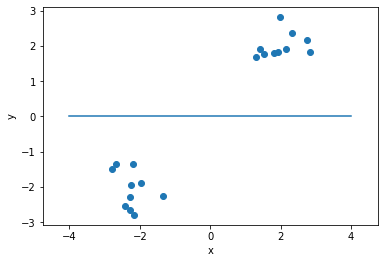

In [29]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

def random_circle(N):
    x = np.reshape(rd.randn(N*2), (N, 2))
    for i in range(N):
        x[i,:] = x[i,:]/np.sqrt(np.sum(x[i,:]**2))
    return x

def random_radius(N, R=1):
    r = rd.rand(N)
    return R*np.sqrt(r) # This ensures uniform sampling from the disc
    

def random_disc(N, mu=[0,0], R=1):
    x = random_circle(N)
    r = random_radius(N, R=R)
    for i in range(N):
        x[i, :] = r[i] * x[i, :] + mu
    return x

N=10

X = np.zeros((20,2))
Y = np.zeros(20)
X[:10,] = random_disc(N, mu=[-2, -2])
X[10:,] = random_disc(N, mu=[2, 2])
Y[:10]=1
Y[10:]=-1

plt.scatter(X[:,0], X[:,1])
plt.plot([-4, 4], [0, 0])
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### Part A

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def backtracking3(v0, b0, z0, dv, db, dz, f, df0, alpha=0.2, beta=0.8):
    '''
    Backtracking for general functions with illustrations
    :param x0: Previous point from backtracking, or initial guess
    :param dx: Incremental factor for updating x0
    :param f: Objective function
    :param df0: Gradient of f at x0
    :param alpha: Sloping factor of stopping criterion
    :param beta: "Agressiveness" parameter for backtracking steps
    :param verbose: Boolean for providing plots and data
    :return: x1, the next iterate in backtracking
    '''

    # Note that the definition below requires that dx and df0 have the same shape
    delta = alpha * (np.sum(dv * df0[:2])+ db*df0[2]+dz*df0[3]) # A general, but memory intensive inner product
    
    t = 1 # Initialize t=beta^0
    f0 = f(v0, b0, z0) # Evaluate for future use
    v = v0 + dv # Initialize x_{0, inner}
    b = b0 + db
    z = z0 + dz
    fx = f(v,b,z)
    
    while (not np.isfinite(fx)) or f0 + delta * t < fx:
        t = beta * t
        v = v0 + t * dv
        b = b0 + t * db
        z = z0 + t * dz
        if(z < 0):
            break
        fx = f(v,b,z)
    ###################################### 

    return v,b,z

In [31]:
# Two steps of the log barrier method

### 0,1,2-order derivatives of original function
fun = lambda v,b,z: z
dfun = lambda v,b,z: np.array([0,0,0,1])
Hfun = lambda v,b,z: np.zeros((4,4))

### 0,1,2-order derivatives of log part
logh = lambda v,b,z: np.sum(np.log((X@v-b)*Y+z-1))
dlogh = lambda v,b,z: np.array([np.sum(Y*X[:,0]*((X@v-b)*Y+z-1)**(-1)), np.sum(Y*X[:,1]*((X@v-b)*Y+z-1)**(-1)), \
                               np.sum(-Y*((X@v-b)*Y+z-1)**(-1)), np.sum(((X@v-b)*Y+z-1)**(-1))])
Hlogh = lambda v,b,z: np.array([[np.sum(-(X[:,0]**2)*((X@v-b)*Y+z-1)**(-2)),np.sum(-(X[:,0]*X[:,1])*((X@v-b)*Y+z-1)**(-2)),\
                                np.sum(X[:,0]*((X@v-b)*Y+z-1)**(-2)), np.sum(-Y*X[:,0]*((X@v-b)*Y+z-1)**(-2))],\
                                \
                                [np.sum(-(X[:,0]*X[:,1])*((X@v-b)*Y+z-1)**(-2)),np.sum(-(X[:,1]**2)*((X@v-b)*Y+z-1)**(-2)),\
                                np.sum(X[:,1]*((X@v-b)*Y+z-1)**(-2)), np.sum(-Y*X[:,1]*((X@v-b)*Y+z-1)**(-2))],\
                                \
                                [np.sum(X[:,0]*((X@v-b)*Y+z-1)**(-2)),np.sum(X[:,1]*((X@v-b)*Y+z-1)**(-2)),\
                                np.sum(-((X@v-b)*Y+z-1)**(-2)), np.sum(Y*((X@v-b)*Y+z-1)**(-2))],\
                                \
                                [np.sum(-Y*X[:,0]*((X@v-b)*Y+z-1)**(-2)),np.sum(-Y*X[:,1]*((X@v-b)*Y+z-1)**(-2)),\
                                np.sum(Y*((X@v-b)*Y+z-1)**(-2)), np.sum(-((X@v-b)*Y+z-1)**(-2))]])

In [32]:
v0=np.array([-20,20])
b0=10
z0=max(1-Y*(X@v0-b0))+1
print(z0)

30.34868309400816


In [33]:
alpha = 0.2
beta = 0.8
t=1

v=v0
b=b0
z=z0

for i in range(5):
    lb = lambda v,b,z: fun(v,b,z) - t*logh(v,b,z)
    dlb = lambda v,b,z: dfun(v,b,z) - t*dlogh(v,b,z)
    for j in range(10):
        v,b,z = backtracking3(v, b, z, -dlb(v,b,z)[:2], -dlb(v,b,z)[2], -dlb(v,b,z)[3], lb,\
                              dlb(v,b,z), alpha=alpha, beta=beta)
    if(z < 0):
        break
    t=t/10
print(v)
print(b)
print(z)
v0=v
b0=b

[-30.646379     8.13582334]
8.306937566605363
-4.118664307639923


### Part B

In [34]:
def backtracking2(v0, b0, dv, db, f, df0, alpha=0.2, beta=0.8):
    '''
    Backtracking for general functions with illustrations
    :param x0: Previous point from backtracking, or initial guess
    :param dx: Incremental factor for updating x0
    :param f: Objective function
    :param df0: Gradient of f at x0
    :param alpha: Sloping factor of stopping criterion
    :param beta: "Agressiveness" parameter for backtracking steps
    :param verbose: Boolean for providing plots and data
    :return: x1, the next iterate in backtracking
    '''

    # Note that the definition below requires that dx and df0 have the same shape
    delta = alpha * (np.sum(dv * df0[:2])+ db * df0[2]) # A general, but memory intensive inner product
    
    t = 1 # Initialize t=beta^0
    f0 = f(v0, b0) # Evaluate for future use
    v = v0 + dv # Initialize x_{0, inner}
    b = b0 + db
    fx = f(v,b)
    
    while (not np.isfinite(fx)) or f0 + delta * t < fx:
        t = beta * t
        v = v0 + t * dv
        b = b0 + t * db
        fx = f(v,b)
    ###################################### 

    return v,b

In [35]:
# Two steps of the log barrier method

### 0,1,2-order derivatives of original function
fun = lambda v,b: np.linalg.norm(v)**2/2
dfun = lambda v,b: np.array([v[0],v[1],0])
Hfun = lambda v,b: np.array([[1,0,0],[0,1,0],[0,0,0]])

### 0,1,2-order derivatives of log part
logh = lambda v,b: np.sum(np.log((X@v-b)*Y-1))
dlogh = lambda v,b: np.array([np.sum(Y*X[:,0]*((X@v-b)*Y-1)**(-1)), np.sum(Y*X[:,1]*((X@v-b)*Y-1)**(-1)), \
                               np.sum(-Y*((X@v-b)*Y-1)**(-1))])
Hlogh = lambda v,b: np.array([[np.sum(-(X[:,0]**2)*((X@v-b)*Y-1)**(-2)),np.sum(-(X[:,0]*X[:,1])*((X@v-b)*Y-1)**(-2)),\
                                np.sum(X[:,0]*((X@v-b)*Y-1)**(-2))],\
                                \
                                [np.sum(-(X[:,0]*X[:,1])*((X@v-b)*Y-1)**(-2)),np.sum(-(X[:,1]**2)*((X@v-b)*Y-1)**(-2)),\
                                np.sum(X[:,1]*((X@v-b)*Y-1)**(-2))],\
                                \
                                [np.sum(X[:,0]*((X@v-b)*Y-1)**(-2)),np.sum(X[:,1]*((X@v-b)*Y-1)**(-2)),\
                                np.sum(-((X@v-b)*Y-1)**(-2))]])

In [36]:
alpha = 0.1
beta = 0.5
t=1

v=v0
b=b0

for i in range(5):
    lb = lambda v,b: fun(v,b) - t*logh(v,b)
    dlb = lambda v,b: dfun(v,b) - t*dlogh(v,b)
    hlb = lambda v,b: Hfun(v,b) - t * Hlogh(v,b)
    nt = lambda v,b: np.linalg.solve(hlb(v,b),dlb(v,b))
    for j in range(2):
        v,b = backtracking2(v, b, -nt(v,b)[:2], -nt(v,b)[2], lb,\
                              dlb(v,b), alpha=alpha, beta=beta)
    t=t/10
print(v)
print(b)
v1=v
b1=b

[-0.31112028 -0.30543208]
0.09134161514974713


D:\Anaconda\envs\learn\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


### Part C

In [37]:
def l2(x):
    return np.sqrt(np.sum(x**2))

f = lambda v,b: np.reshape(np.sum(v**2)/2, (1, 1)) # Reshape coerces dimension for block
df = lambda v,b: np.reshape(np.array([v[0],v[1],0]),(3,1))
d2f = lambda v,b: np.array([[1,0,0],[0,1,0],[0,0,0]])

conh = lambda v,b: np.reshape(1-(X@v-b)*Y, (20, 1))
condh = lambda v,b: np.array([-X[:,0]*Y,-X[:,1]*Y,Y]).T

phi = lambda v, b, mu, t:  np.concatenate((df(v,b)+(condh(v,b).T)@mu, -mu*conh(v,b)-1/t))
dphi = lambda v, b, mu: np.reshape(np.block([[d2f(v,b), condh(v,b).T], \
                                             [-np.diag(np.reshape(mu,20))@condh(v,b),\
                                             np.diag(-np.reshape([conh(v,b)],20))]]), (d+m, d+m)) 
# block is new in numpy 1.13.0

def diagnostic(d, x, mu, t, dx_mu):
    n = 100
    s = np.linspace(0, 1.0, n)
    vals = np.zeros(n)
    for i in range(n):
        vals[i] = l2(phi(x + s[i]*dx_mu[:d], mu + s[i]*dx_mu[d:], t))
        
    plt.plot(s, vals)
    plt.show()
    

num_iter = 10
d = 3 # dimension of the program
m = 20 # number of inequality constraints
 # initial values for x_1, x_2 -- dimension is coerced to ensure column vector format
mu0 = -1/conh(v0,b0) # initial value for mu


nu = 10 # Interior point scaling parameter

# Backtracking parameters
alpha = 0.1
beta = 0.5

eta = lambda v, b, mu: -np.sum(conh(v,b)*mu) # Computation of surrogate duality gap

v=v0
b=b0
mu = mu0
for i in range(num_iter):
    t = nu * m / eta(v, b, mu)
    phi0 = phi(v,b,mu,t)
    norm_phi0 = l2(phi0)
    
    # Compute the Newton search direction

    dx_mu = np.linalg.solve(dphi(v, b, mu), -phi0)
    
    # Initialize backtracking
    s = 1 # using s for backtracking parameter since t is taken
    yv = v + np.reshape(s*dx_mu[:2],2)
    yb = b + s*dx_mu[2,0]
    ymu = mu + s*dx_mu[d:]
    hyx = conh(yv, yb)
    phiy = phi(yv, yb, ymu, t)
    norm_phiy = l2(phiy)
    
    #diagnostic(d, x, mu, t, dx_mu)
    
    while 0 < ymu[ymu<=0].size or 0 < hyx[0<=hyx].size or (1-alpha*s)*norm_phi0 < norm_phiy:
        s = beta * s
        yv = v + np.reshape(s*dx_mu[:2],2)
        yb = b + s*dx_mu[2,0]
        ymu = mu + s*dx_mu[d:]
        hyx = conh(yv, yb)
        phiy = phi(yv, yb, ymu, t)
        norm_phiy = l2(phiy)
        
    v = yv
    b = yb
    mu = ymu
    
print(v)
print(b)
print(mu)
v2=v
b2=b

[-0.31226181 -0.29954512]
0.09349597790128443
[[1.79546535e-04]
 [2.20235312e-04]
 [1.53187849e-02]
 [8.28981050e-04]
 [1.25949315e-04]
 [1.39907090e-04]
 [2.74152138e-04]
 [1.61858587e-04]
 [7.57244803e-02]
 [1.46856049e-04]
 [4.56521291e-04]
 [9.14671381e-02]
 [8.40094262e-05]
 [6.93448160e-05]
 [1.13977639e-04]
 [7.93465852e-05]
 [4.23275791e-04]
 [6.54201206e-05]
 [1.62981205e-04]
 [1.98736338e-04]]


### Part D

0.19008458162167846 0.18723471459789118


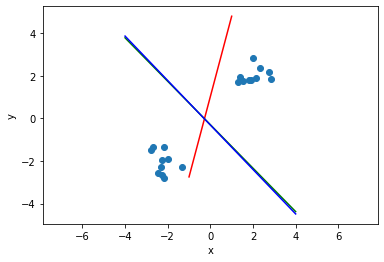

In [38]:
print(np.sum(v1**2),np.sum(v2**2))

def linear(x,v,b):
    return (b-x*v[0])/v[1]

point = np.array([-1,1])
points=np.array([-4,4])

plt.scatter(X[:,0], X[:,1])
plt.plot(point, linear(point,v0,b0),color='red')
plt.plot(points, linear(points,v1,b1),color='green')
plt.plot(points, linear(points,v2,b2),color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### Comment
The two results are similar. And the result from primal-dual algorithm is a little better than the first one. And it didn't throw out value warnings.

## Problem 2

Recall the BCW dataset from HW07. We will use kernel SVMs to train classifiers for this dataset. Instead of coding this up, use the *sklearn.svm* package to fit a kernel SVM using an *rbf* or **Radial Basis Function** kernel. 

### Part A

The Python package *sklearn.svm* is powered by [LIBSVM](http://www.csie.ntu.edu.tw/~cjlin/libsvm). Follow this link and read the documentation. Summarize the optimization program that is LIBSVM is using, and explain the Sequential Minimal Optimization numerical routine that LIBSVM uses. Why do you think they use this approach instead of the log-barrier method or the primal-dual algorithm?

### Part B

Use the same experimental setup as in HW07 to randomly split and test data, training a kernel SVM with an rbf kernel instead of logisitic regression for each random split of the data. Compare and contrast the ROC curves for this approach versus the ROC curves you obtained in HW07.


## Solution to Problem 2

### Part A
#### (1) Adjustments to the Orignal Program
What they want to solve for the original problem is:
$$\min_{w,b,\xi}\frac{1}{2}w^Tw+C\sum_{i=1}^{l}\xi_i$$
$$subject\ to\ y_i(w^T\phi(x_i)+b)\geq 1-\xi_i$$
$$\xi_i \geq0$$
The variables $\xi_i$ are introduced for the regard that:  
  
The original program is under the assumption that the given dataset could be somhow separated by some line. But in practical examples, many datasets just cannot be separated by any line (hyper-line or hyper-plane). That may be due to:  
  
**(A)** errors (systematic errors or errors caused by inaccuracy of measurement);  
**(B)** data with labels just doesn't form to the two sides of any line. (For example, data with two labels form in the inner space and outer space of a unit circle)  
  
If the given dataset cannot be separated by any line, then the feasible set of the original version of SVM program is empty. Thus we couldn't find any solution to the orinal program.  
  
So $\xi_i$s are introduced to guarantee that errors of line-separating could happen. And we add a new penalty function to the objective function to ensure that $\xi_i$ wouldn't be too large. By selecting an appropriate cofficient of $C$, we can make sure that $\xi$ is just reasonable for the program.

In short summary, $\xi_i$s solve the problems that program couldn't process normally and **(A)** the influence of errors.

#### (2) Kernal Functions and the Dual Program of SVM:
Although the program could process normally after $\xi$s are introduced, if **(B)** data is born not to be classified by hyper-planes, result of the program won't be good. The repaired program becomes meanless in those situations.
  
It's OK to solve the best circle when data is born to be classified by a circle, and solve the best hyperbolic curve when the data is born to be classified by a hyperbolic.
  
But that requires observations of the original dataset. And this method is not automatic.  
  
An equivalent (mathematically proved) method is to use a mapping $\phi(x)$ to map the original dataset into a high-dimension space and then solve the best hyper-plane that separates the data.
  
Then what we have for the program is: (As mentioned in the beginning)
$$\min_{w,b,\xi}\frac{1}{2}w^Tw+C\sum_{i=1}^{l}\xi_i$$
$$subject\ to\ y_i(w^T\phi(x_i)+b)\geq 1-\xi_i$$
$$\xi_i \geq0$$

And the dual program of the above one turns out to be:
$$\min_{\alpha}\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_i\alpha_jy_iy_j(<\phi(x_i),\phi(x_j)>)-\sum_{i=1}^{N}\alpha_i$$
$$s.t.\ \sum_{i=1}^{N}\alpha_iy_i=0$$
$$\alpha_i\geq0,\ i=1,2,\cdots,N$$

The definition of kernal function is: $K(x,y)=<\phi(x),\phi(y)>$, the inner product of the two points in the high-dimension space formed by the mapping, then $K(x_i,x_j)=<\phi(x_i),\phi(x_j)>$.
  
We notice that in the program we can focus on $K(x_i,x_j)$ instead of $\phi(x_i)$. There are two reasons why we focus on kernal function $K(x,y)$ instead of the mapping $\phi(x)$:  
  
**(A)** It's faster and more convenient to numerically calculate $K(x_i,x_j)$ than calculate $\phi(x_i)$ and $\phi(x_j)$ and finally the innder product of them.  
**(B)** It can be mathematically proved that if bivariate function $K(x,y)$ satisfy some conditions, then it could be written as $K(x,y)=<\phi(x),\phi(y)>$ with some mapping $\phi(x)$
  
So we can focus on finding kernal functions with great features. Plus, some kernal functions are just hard to be written in the inner product form, such as RBF.

#### (3) SMO Algorithm
SMO algorithm is an algorithm mostly applied to solving the dual program of SVM:
$$\min_{\alpha}\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_i\alpha_jy_iy_jK_{ij}-\sum_{i=1}^{N}\alpha_i$$
$$s.t.\ \sum_{i=1}^{N}\alpha_iy_i=0$$
$$\alpha_i\geq0,\ i=1,2,\cdots,N$$
$$(K_{ij}=K(x_i,x_j))$$
The basic idea is that at each step, we select two variables $\alpha_i$, $\alpha_j$, fix all the other variables, and compute the minimum with these two free variables only.  
  
That is a sub-program as:
$$\min_{\alpha_1,\alpha_2}W(\alpha_1,\alpha_2)=\frac{1}{2}K_{11}\alpha_1^2+\frac{1}{2}K_{22}\alpha_2^2+y_1y_2K_{12}\alpha_1\alpha_2-(\alpha_1+\alpha_2)+y_1\alpha_1\sum_{i=3}^{N}y_i\alpha_iK_{i1}+y_2\alpha_2\sum_{i=3}^{N}y_i\alpha_iK_{i2}$$
$$s.t.\ \alpha_1y_1+\alpha_2y_2=-\sum_{i=3}^{N}y_i\alpha_i=\varsigma$$
$$0\leq\alpha_i\leq C\ \ \ i=1,2$$
That's a easy but complex quadratic program. We can skip all the reduction process and look at the result:  
  
If we mark:
$$E_i=(\sum_{j=1}^{N}\alpha_jy_jK(x_j,x_i)+b)-y_i\ \ \ i=1,2$$
$$\eta=K_{11}+K_{22}-2K_{12}=\Vert\phi(x_1)-\phi(x_2)\Vert^2$$
$$\alpha_2^{new,unc}=\alpha_2^{old}+\frac{y_2(E_1-E_2)}{\eta}$$
$$H=\begin{cases}
min(C,C+\alpha_2^{old}-\alpha_1^{old})&when\ y_1\neq y_2\\
min(C,\alpha_2^{old}+\alpha_1^{old})&when\ y_1=y_2
\end{cases}$$
$$L=\begin{cases}
max(0,\alpha_2^{old}-\alpha_2^{old})&when\ y_1\neq y_2\\
max(0,\alpha_2^{old}+\alpha_2^{old}-C)&when\ y_1=y_2
\end{cases}$$
Then we have:
$$\alpha_2^{new}=\begin{cases}
H&when\ \alpha_2^{new,unc}>H\\
\alpha_2^{new,unc}&when\ L\leq\alpha_2^{new,unc}\leq H\\
L&when\ \alpha_2^{new,unc}<L
\end{cases}$$
$$\alpha_1^{new}=\alpha_1^{old}+y_1y_2(\alpha_2^{old}-\alpha_2^{new})$$
That's the computation process of one step.  
$$$$
$$$$
As for how to select the two free variables at each step, we have the strategy below:  

**(A)** Selection of the First Variable:  
  
Select the variable that violates KKT conditions most. The verification rules of KKT conditions are:
$$\alpha_i=0\Leftrightarrow y_ig(x_i)\geq1$$
$$0<\alpha_i<C\Leftrightarrow y_ig(x_i)=1$$
$$\alpha_i=C\Leftrightarrow y_ig(x_i)\leq1$$
$$in\ which\ \ \ g(x_i)=\sum_{j=1}^{N}\alpha_jy_jK(x_i,x_j)+b$$
**(B)** Selection of the Second Variable:  
  
Suppose the first variable is $\alpha_i$, we select the variable $\alpha_j$ with the biggest value of $\vert E_i-E_j\vert$ to accelerate the process.
$$$$
$$$$  

   
And before updating $\alpha_i$ at each step, we need to update $b$ first:
$$b_1^{new}=y_1-\sum_{i=3}^{N}\alpha_iy_iK_{i1}-\alpha_1^{new}y_1K_{11}-\alpha_2^{new}y_2K_{21}$$

That's the whole thing for SMO.

### Comment
#### Why use SMO
(1) Methods of log-barrier and primal-dual used in **Problem 1** focus on the original variables or original variables as well as dual variables. So it will be hard to do computations when we map the data into a higher-dimension space with $\phi(x)$. They cannot fit well with kernal functions.  

(2) The two methods both use iteration steps which require a gradient descent direction. But SMO doesn't require that. SMO is the algorithm fit well with the dual program of SVM with efficiency and stability.----Since the dual program of SVM is a program with only one equation restriction and some simple inequation restriction, it is reasonable to use a method that is more specialized designed for the program. Log-barrier and primal-dual are more general methods while SMO is special for SVM.

### Part B

In [1]:
### Load the BCW data using scikit-learn
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
BCW = load_breast_cancer()
print(BCW.data.shape)

(569, 30)


In [2]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
y=BCW.target
one = np.ones((569,1))
X=scale(BCW.data)
X = np.concatenate((one, X), axis=1)

In [52]:
from sklearn.metrics import roc_curve
from numpy.random import shuffle
order=np.arange(569)
shuffle(order)

test=[X[order[0:114],], X[order[114:228],], X[order[228:342],], X[order[342:456],], X[order[456:569],]]
train=[X[order[114:569],], X[order[np.append(np.arange(114), np.arange(228,569))],], \
       X[order[np.append(np.arange(228), np.arange(342,569))],],\
      X[order[np.append(np.arange(342), np.arange(456,569))],],\
      X[order[:456],]]

target_train=[y[order[114:569],], y[order[np.append(np.arange(114), np.arange(228,569))],], \
       y[order[np.append(np.arange(228), np.arange(342,569))],],\
      y[order[np.append(np.arange(342), np.arange(456,569))],],\
      y[order[:456],]]
target_test=[y[order[0:114],], y[order[114:228],], y[order[228:342],], y[order[342:456],], y[order[456:569],]]

### SVM

In [100]:
####SVM
from libsvm.svmutil import *
svm_model.predict = lambda self, x: svm_predict([0], [x], self)[0][0]

predict=[]

for i in range(5):
    prob = svm_problem(target_train[i],train[i])

    param = svm_parameter()
    param.kernel_type = RBF
    param.C = 2**(1)
    param.gamma=2**(-5)
    m=svm_train(prob, param)

    one_predict=[]
    for point in test[i].tolist():
        one_predict.append(m.predict(point))
    predict.extend(one_predict)

predict=np.array(predict)
predict.shape
fpr, tpr, thersholds = roc_curve(y[order], predict, pos_label=1)

Accuracy = 100% (1/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 100% (1/1) (classification)
Accuracy = 0% 

### Logistic Regression

In [54]:
#####logistic regression
def logit(x):
    return 1/(1+np.exp(-x))

def ell(b,y,X,lam):
    return np.sum(np.log(1+np.exp(((-1)**y)*(X@b))))+lam*(np.linalg.norm(b)**2)

def Dell(b,y,X,lam):
    return X.T @ (((-1)**y)*logit(((-1)**y)*(X@b)))+2*lam*b

def D2ell(b,y,X,lam):
    return (X.T * (logit(-X@b)*logit(X@b))) @ X+2*lam*np.identity(len(b))

In [37]:
def backtracking(x0, dx, f, df0, alpha=0.2, beta=0.8):
    '''
    Backtracking for general functions with illustrations
    :param x0: Previous point from backtracking, or initial guess
    :param dx: Incremental factor for updating x0
    :param f: Objective function
    :param df0: Gradient of f at x0
    :param alpha: Sloping factor of stopping criterion
    :param beta: "Agressiveness" parameter for backtracking steps
    :param verbose: Boolean for providing plots and data
    :return: x1, the next iterate in backtracking
    '''

    # Note that the definition below requires that dx and df0 have the same shape
    delta = alpha * np.sum(dx * df0) # A general, but memory intensive inner product; df0.T @ dx in Python 3.5+
    
    t = 1 # Initialize t=beta^0
    f0 = f(x0) # Evaluate for future use
    x = x0 + dx # Initialize x_{0, inner}
    fx = f(x)
    
    while (not np.isfinite(fx)) or f0 + delta * t < fx:
        t = beta * t
        x = x0 + t * dx
        fx = f(x)

    return x

In [55]:
#####logistic regression
import matplotlib.pyplot as plt
max_steps = 10000
lam=0.01
stop_limit=1e-6

predict=[]

for index in range(5):
    print('#######')
    print('Training set', index)
    f = lambda b: ell(b,target_train[index],train[index],lam) # initialize the negative log likelihood as a function of just b
    b = rd.randn(31) # Initialize \beta_0

    def nt_4(b):
        k2=0
        while(k2 < max_steps):
            gra=Dell(b,target_train[index],train[index],lam)
            v = np.linalg.solve(D2ell(b,target_train[index],train[index],lam),gra)
            b = backtracking(b, -v, f, gra)
            if(np.linalg.norm(gra) < stop_limit):
                break;
            k2=k2+1
        return k2, b

    k, b=nt_4(b)
    print('Newton Steps:', k)
    print('Predicting set', index)
    one_predict=logit(test[index]@b)
    predict.extend(one_predict)
print('#######')
predict=np.array(predict)
print('Prediction Complete')

#print(predict.shape)
fpr1, tpr1, thersholds = roc_curve(y[order], predict, pos_label=1)

#######
Training set 0
Newton Steps: 13
Predicting set 0
#######
Training set 1
Newton Steps: 12
Predicting set 1
#######
Training set 2
Newton Steps: 12
Predicting set 2
#######
Training set 3
Newton Steps: 11
Predicting set 3
#######
Training set 4
Newton Steps: 13
Predicting set 4
#######
Prediction Complete


### ROC Curve

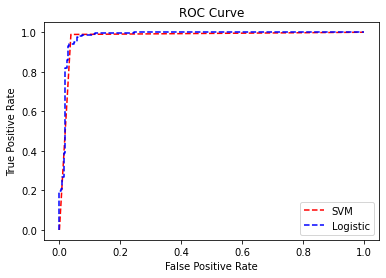

In [101]:
plt.plot(fpr, tpr, 'k--', color='red',label='SVM')
plt.plot(fpr1, tpr1, 'k--', color='blue',label='Logistic')
 
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Comment
The ROC curve of SVM is sharper in the corner than Logistic Regression. And SVM is faster than Logistic Regression. With the right parametres of $C$ and $\gamma$, SVM could perform better than Logistic Regression.